In [49]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(30, 20), dpi=80, facecolor='w', edgecolor='k')
import seaborn as sns 
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
import keras.backend as K


from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX



<Figure size 2400x1600 with 0 Axes>

In [3]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [4]:
dir_name="/home/aniket/Music/notebooks/data/m5-forecasting-uncertainty"
data_folder = Path(dir_name)

In [5]:
calender_data = pd.read_csv(data_folder/"calendar.csv")

In [6]:
sales_data = pd.read_csv(data_folder/"sales_train_validation.csv")
sell_prices_data = pd.read_csv(data_folder/"sell_prices.csv")

In [7]:
calender_data.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [8]:
sales_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [9]:
sell_prices_data

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [10]:
prediction_columns = [col for col in sales_data.columns if 'd_' in col]

In [11]:
sales_data_hobbies = sales_data[sales_data['cat_id']=='HOBBIES'][prediction_columns]

In [12]:
sales_data_hobbies.iloc[1]

d_1       0
d_2       0
d_3       0
d_4       0
d_5       0
         ..
d_1909    1
d_1910    0
d_1911    0
d_1912    0
d_1913    0
Name: 1, Length: 1913, dtype: int64

In [13]:
sales_data_hobbies_std = sales_data_hobbies.sub(sales_data_hobbies.mean(0),axis=1).div(sales_data_hobbies.std(0), axis=1)

In [14]:
sales_data_hobbies_std

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,-0.23891,-0.245991,-0.204825,-0.226332,-0.193577,-0.209458,-0.206058,-0.233463,-0.247985,-0.197495,...,0.183634,0.993519,-0.332950,0.210300,0.167724,0.213695,1.280742,-0.354442,0.070831,0.079421
1,-0.23891,-0.245991,-0.204825,-0.226332,-0.193577,-0.209458,-0.206058,-0.233463,-0.247985,-0.197495,...,-0.372982,-0.373820,-0.332950,-0.300312,-0.340941,0.213695,-0.315829,-0.354442,-0.392896,-0.384621
2,-0.23891,-0.245991,-0.204825,-0.226332,-0.193577,-0.209458,-0.206058,-0.233463,-0.247985,-0.197495,...,0.740251,0.081960,0.447617,0.210300,0.167724,0.213695,-0.315829,0.135790,0.070831,0.079421
3,-0.23891,-0.245991,-0.204825,-0.226332,-0.193577,-0.209458,-0.206058,-0.233463,-0.247985,-0.197495,...,0.183634,-0.373820,1.618468,1.742133,0.167724,-0.340656,0.216361,1.116252,2.853194,0.543463
4,-0.23891,-0.245991,-0.204825,-0.226332,-0.193577,-0.209458,-0.206058,-0.233463,-0.247985,-0.197495,...,0.740251,0.081960,0.057334,-0.300312,0.167724,0.213695,0.748552,0.626021,0.534558,1.471548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28001,-0.23891,-0.245991,-0.204825,-0.226332,-0.193577,-0.209458,-0.206058,-0.233463,-0.247985,-0.197495,...,-0.372982,-0.373820,-0.332950,-0.300312,-0.340941,-0.340656,1.812933,-0.354442,-0.392896,-0.384621
28002,-0.23891,0.582039,-0.204825,-0.226332,-0.193577,-0.209458,-0.206058,-0.233463,-0.247985,-0.197495,...,-0.372982,-0.373820,-0.332950,-0.300312,-0.340941,-0.340656,-0.315829,-0.354442,-0.392896,-0.384621
28003,-0.23891,-0.245991,-0.204825,-0.226332,-0.193577,-0.209458,-0.206058,-0.233463,-0.247985,-0.197495,...,0.183634,-0.373820,-0.332950,-0.300312,-0.340941,0.768045,-0.315829,0.135790,0.534558,-0.384621
28004,-0.23891,-0.245991,-0.204825,0.252790,-0.193577,-0.209458,-0.206058,0.097462,-0.247985,-0.197495,...,-0.372982,-0.373820,-0.332950,-0.300312,-0.340941,-0.340656,-0.315829,-0.354442,-0.392896,-0.384621


In [15]:
x_axis_range  = np.tile(range(0,sales_data_hobbies.shape[1]),(sales_data_hobbies.shape[1],1))

In [16]:
sales_data_hobbies.iloc[0]

d_1       0
d_2       0
d_3       0
d_4       0
d_5       0
         ..
d_1909    1
d_1910    3
d_1911    0
d_1912    1
d_1913    1
Name: 0, Length: 1913, dtype: int64

for i in range(0,sales_data_hobbies_std.shape[0]):
    plt.plot(range(0,sales_data_hobbies_std.shape[1]),sales_data_hobbies_std.iloc[i])

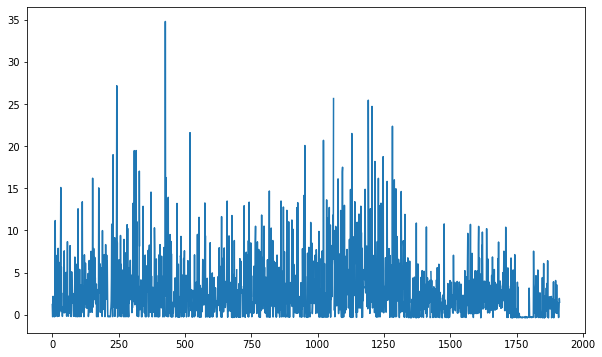

In [17]:
plt.plot(range(0,sales_data_hobbies.shape[1]),sales_data_hobbies_std.iloc[14])

#### sales_data_hobbies_std.iloc[0]

In [18]:
plt.savefig('hobbies.png')

<Figure size 720x432 with 0 Axes>

In [19]:
sales_data.iloc[14]

id          HOBBIES_1_015_CA_1_validation
item_id                     HOBBIES_1_015
dept_id                         HOBBIES_1
cat_id                            HOBBIES
store_id                             CA_1
                        ...              
d_1909                                  0
d_1910                                  0
d_1911                                  2
d_1912                                  5
d_1913                                  4
Name: 14, Length: 1919, dtype: object

# EDA

## Analysis for same item in different stores and states

In [20]:
def get_prediction(sales_data,item_id,store_id):
    prediction_columns = [col for col in sales_data.columns if 'd_' in col]
    data = sales_data.loc[(sales_data['item_id']==item_id) & (sales_data['store_id']==store_id)]
    return data[prediction_columns].values.flatten()

In [21]:
HOBBIES_1_001_CA_1_validation_pred = get_prediction(sales_data,'HOBBIES_1_001','CA_1')
HOBBIES_1_001_CA_2_validation_pred = get_prediction(sales_data,'HOBBIES_1_001','CA_2')
HOBBIES_1_001_CA_3_validation_pred = get_prediction(sales_data,'HOBBIES_1_001','CA_3')

In [22]:
corr = np.corrcoef(HOBBIES_1_001_CA_1_validation_pred,HOBBIES_1_001_CA_2_validation_pred)

In [23]:
corr

array([[1.        , 0.19255759],
       [0.19255759, 1.        ]])

In [24]:
prediction_data = sales_data[prediction_columns]

corrmat = prediction_data.corr()

heat_map = sns.heatmap(corrmat)

In [25]:
calender_data['is_event'] = calender_data[['event_name_1','event_name_2']].apply(lambda x : 0 if(pd.isna(x['event_name_1']) & pd.isna(x['event_name_2']) ) else 1,axis=1)

In [26]:
calender_data.event_name_1.value_counts()

Pesach End             6
LentStart              6
Mother's day           6
ValentinesDay          6
Ramadan starts         6
StPatricksDay          6
NBAFinalsEnd           6
SuperBowl              6
Purim End              6
NBAFinalsStart         6
PresidentsDay          6
LentWeek2              6
MemorialDay            6
Eid al-Fitr            5
Christmas              5
EidAlAdha              5
MartinLutherKingDay    5
OrthodoxEaster         5
VeteransDay            5
Thanksgiving           5
LaborDay               5
ColumbusDay            5
OrthodoxChristmas      5
Cinco De Mayo          5
Chanukah End           5
IndependenceDay        5
NewYear                5
Easter                 5
Halloween              5
Father's day           4
Name: event_name_1, dtype: int64

In [27]:
p1 = prediction_data.iloc[0,:]
p2 = prediction_data.iloc[2,:]

p1 = (p1-p1.mean())/p1.std()
p2 = (p2-p2.mean())/p2.std()

np.linalg.norm(p1-p2)

56.21507647565369

In [28]:
eucledian_matrix = np.zeros([len(prediction_data),len(prediction_data)])

for i in range(0,len(prediction_data)-1):
    for j in range(i+1,len(prediction_data)):
        p1 = prediction_data.iloc[i,:]
        p2 = prediction_data.iloc[j,:]
        p1 = (p1-p1.mean())/p1.std()
        p2 = (p2-p2.mean())/p2.std()
        eucledian_matrix[i][j] = np.linalg.norm(p1-p2)
    

eucledian_matrix.dump(dir_name/"eucledian_matrix.dat")

eucledian_matrix = np.zeros([len(prediction_data)])
for j in range(0,len(prediction_data)):
        p1 = prediction_data.iloc[0,:]
        p2 = prediction_data.iloc[j,:]
        p1 = (p1-p1.mean())/p1.std()
        p2 = (p2-p2.mean())/p2.std()
        eucledian_matrix[j] = np.linalg.norm(p1-p2)



eucledian_matrix

eucledian_matrix[0] = 1000

np.argmin(eucledian_matrix,axis=0)

In [29]:
prediction_data

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,0,0,0,0,0,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,0,0,0,0,0,0,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,0,0,2,2,0,3,1,4,1,0,...,2,0,0,0,0,0,1,0,0,1
30486,0,0,0,0,0,5,0,1,1,3,...,0,0,0,0,0,0,0,0,1,0
30487,0,6,0,2,2,4,1,8,5,2,...,2,1,0,2,0,1,0,0,1,0
30488,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [30]:
np.sqrt(np.sum(np.square(p1.values - p2.values)))

56.21507647565369

## Pin Ball Loss Function

In [31]:
def SPL(u,h,n,Q,y):
    denominator = 0
    for t in range(1,n):
        denominator = denominator + abs(y[t]-y[t-1])
    denominator = denominator/(n-1)
    
    numerator = 0 
    # Check the indices start and end
    for t in range(n+1,n+h):
        i1 = 1 if (Q[t] <= y[t]) else 0
        i2 = 1 if (Q[t] > y[t]) else 0
        term1 = (y[t] - Q[t])*u
        term2 = (Q[t] - y[t])*(1 - u)
        numerator = numerator + term1*i1 + term2*i2
    
    loss = numerator/(h*denominator)
    return loss
        
    

# ARIMA

In [32]:
series = prediction_data.iloc[14,:]
p1_rolling_mean = series.rolling(window=20).mean()

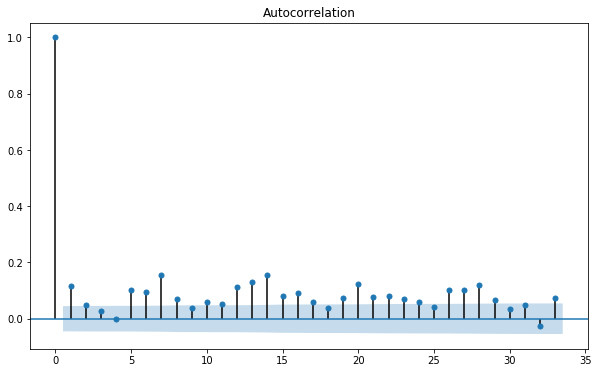

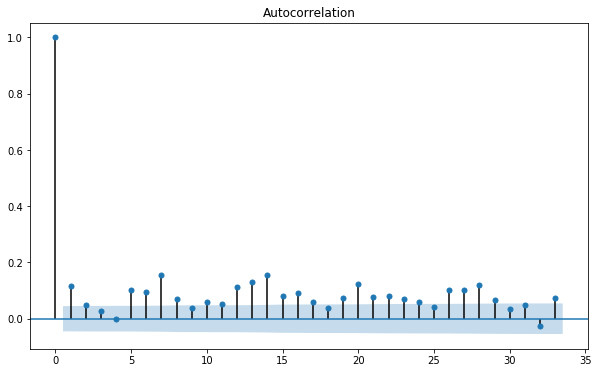

In [33]:
plot_acf(series)

In [34]:
acf_val = acf(series)

/home/aniket/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [35]:
acf_cutoff = 0.115

In [36]:
T = np.where(acf_val >= acf_cutoff)

In [37]:
T = np.delete(T,0)

In [38]:
range_T = np.amax(T)

In [39]:
data_acf = []
label_acf = []

In [58]:
for i in range(range_T,series.shape[0]):
    temp = []
    for t in T : 
        temp.append(series[i - t])
    temp.append(series[i] - series[i-1])
    data_acf.append(temp)
    label_acf.append(series[i])

In [59]:
len(data_acf)

5655

In [60]:
X_train = data_acf[0:1500]
X_test = data_acf[1500:1877]
y_train = label_acf[0:1500]
y_test = label_acf[1500:1877]

In [65]:
#clf = RandomForestClassifier(max_depth=5, random_state=0)
#clf.fit(X_train,y_train)
#y_pred = clf.predict(X_test)


reg = LinearRegression().fit(X_train,y_train)
y_pred = reg.predict(X_test)

In [66]:
train_series = series[0:1500]
test_series = series[1500:1800]
history = [x for x in train_series]
predictions = list()

In [67]:
for t in range(len(test_series)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_series[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

In [68]:
model_without_loop = ARIMA(history, order=(5,1,0))
model_without_loop_fit = model_without_loop.fit(disp=0)

output = model_without_loop_fit.predict(start=1500, end=1800)

In [69]:
# define model configuration
my_order = (5,1,0)
my_seasonal_order = (5,1,0,12)
# define model
model = SARIMAX(history, order=my_order, seasonal_order=my_seasonal_order)
model_fit = model.fit()
output_sarima = model_fit.predict(start=1500, end=1800)

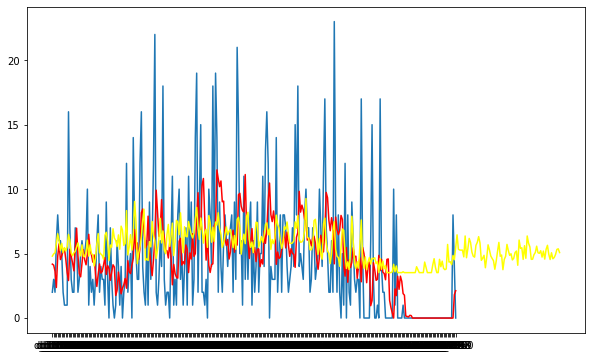

In [70]:
pyplot.plot(test_series)
pyplot.plot(predictions, color='red')
#pyplot.plot(output, color='green')
#pyplot.plot(output_sarima, color='orange')
pyplot.plot(y_pred, color='yellow')

([<matplotlib.axis.XTick at 0x7f033426cb90>,
 <a list of 10 Text xticklabel objects>)

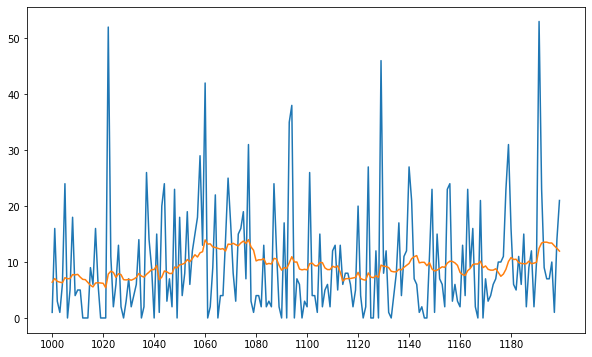

In [75]:
#plt.plot(range(800,1913),HOBBIES_1_001_CA_1_validation_pred[800 :])
#plt.plot(range(800,1913),HOBBIES_1_001_CA_2_validation_pred[800 :])
plt.plot(range(1000 ,1200),get_prediction(sales_data,'HOBBIES_1_015','CA_1')[1000 :1200])
plt.plot(range(1000 ,1200),p1_rolling_mean[1000 :1200])
#plt.plot(range(1000 ,1400),calender_data['is_event'][1000 : 1400])
plt.xticks(np.arange(1000 ,1200,20))

In [76]:
p1.transpose()

d_1      -0.457706
d_2      -0.457706
d_3      -0.457706
d_4      -0.457706
d_5      -0.457706
            ...   
d_1909    1.001614
d_1910    3.920256
d_1911   -0.457706
d_1912    1.001614
d_1913    1.001614
Name: 0, Length: 1913, dtype: float64

# NN as Linear Regression

In [113]:
X_train = np.asarray(X_train)

In [99]:
data_shape = len(X_train[0])

In [100]:
def reg_model(data_shape):
    model = keras.Sequential()
    model.add(keras.layers.Dense(1, input_dim=data_shape, activation='linear'))
    return model

In [103]:
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

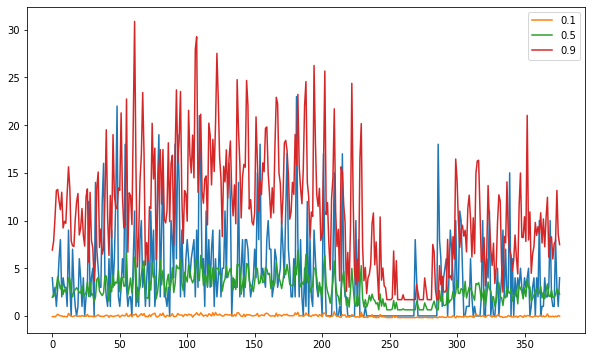

In [118]:
qs = [0.1, 0.5, 0.9]
plt.plot(y_test)
for q in qs:
    model = reg_model(data_shape)
    model.compile(loss=lambda y,f: tilted_loss(q,y,f),  optimizer=keras.optimizers.Adam(0.001))
    model.fit(np.asarray(X_train),np.asarray(y_train), epochs=5, batch_size=1, verbose=0)
    
    # Predict the quantile
    y_pred = model.predict(np.asarray(X_test))
    plt.plot(y_pred, label=q) # plot out this quantile

plt.legend()    
plt.savefig('quantile.png')
plt.show()

# SVM

In [94]:
order = 5

In [116]:
x_train_svm = []
y_train_svm = []
x_test_svm = []
y_test_svm = []
diff_train_svm = []
diff_test_svm = []
series_x = []
series_y = []
diff_svm = []
diff_svm_agg = []


In [119]:
for i in range(0,series.shape[0]-order):
        series_x.append(series[i:i+order].values)
        series_y.append(series.iloc[i+order])
        if i != 0 : 
            diff_svm.append(series[i] - series[i-1])
    
   # print ("i: ",i," x: ",series[i:i+order].values," y: ",series.iloc[i+order])
    

In [122]:
for i in range(0,len(diff_svm)-order):
        diff_svm_agg.append(diff_svm[i:i+order])



In [123]:
diff_train_svm = diff_svm_agg[0:1500]
diff_test_svm = diff_svm_agg[1500:1800]
y_train_svm = series_y[0:1500]
y_test_svm = series_y[1500:1800]
x_train_svm = series_x[0:1500]
x_test_svm = series_x[1500:1800]


In [124]:
def inverse_difference(i):
    return series_x[i-1]+diff_svm[i]

In [83]:
clf = SVC(gamma='auto')
clf.fit(diff_train_svm,y_train_svm)
y_pred= clf.predict(diff_test_svm)

NameError: name 'diff_train_svm' is not defined

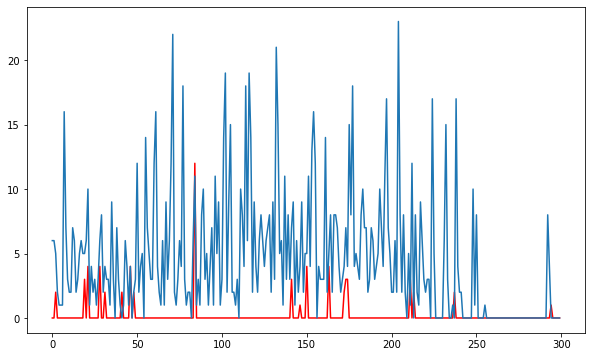

In [130]:
plt.plot(y_pred,color='red')
plt.plot(y_test_svm)

# Data Preparation

In [33]:
history_size=3

In [34]:
categorical_features = ['event_name_1']
categorical_transformer = Pipeline(steps=[
       ("Imputer2", SimpleImputer(missing_values=np.nan, strategy='constant')),
                        ("Encoding", OneHotEncoder())
                        ])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
    ])

In [35]:
calender_data_transform = preprocessor.fit_transform(calender_data[categorical_features])

In [36]:
calender_data_transform = calender_data_transform.todense()

In [37]:
calender_data_transform[1]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [38]:
event_one_hot_shape = calender_data_transform.shape[1]

In [39]:
shape = (history_size+2,1)

In [40]:
current_price = sell_prices_data[(sell_prices_data['wm_yr_wk']==11500) & (sell_prices_data['item_id']=='HOBBIES_1_015') & (sell_prices_data['store_id']=='CA_1')].sell_price

In [41]:
price_HOBBIES_1_015 = sell_prices_data[ (sell_prices_data['item_id']=='HOBBIES_1_015') & (sell_prices_data['store_id']=='CA_1')].sell_price

In [42]:
price_HOBBIES_1_015

3318    0.70
3319    0.70
3320    0.70
3321    0.72
3322    0.72
        ... 
3595    0.70
3596    0.70
3597    0.70
3598    0.70
3599    0.70
Name: sell_price, Length: 282, dtype: float64

In [53]:
def get_data(dataset,history_size,shape,item_id,store_id):
    data=[]
    label=[]
    dataset_size = len(dataset)
   # dataset_normalizer = Normalizer().fit(dataset.reshape(-1, 1)) 
    #dataset = dataset_normalizer.transform(dataset.reshape(-1, 1))
    
    sale_data = sell_prices_data[(sell_prices_data['item_id']==item_id) & (sell_prices_data['store_id']==store_id)]
    
    for i in reversed(range(history_size,dataset_size-1)):
        x = dataset[i-history_size:i]
        x = np.append(x,calender_data[['wday','month']].iloc[i].values)
        wm_yr_wk = calender_data['wm_yr_wk'].iloc[i]
        #current_price = sell_prices_data[sell_prices_data['wm_yr_wk']==wm_yr_wk].sell_price.values[0]
       # x = np.append(x,current_price)
        y = dataset[i]
        data.append(x.reshape(shape))
        label.append(y)
    return np.array(data),np.array(label)

In [54]:
p1 = prediction_data.iloc[14,:]

In [55]:
train_data = p1[0:1800].values

In [56]:
train_x,train_y = get_data(train_data,history_size,shape,'HOBBIES_1_015','CA_1')

In [57]:
test_data = p1[1800:1900].values

In [58]:
test_x,test_y = get_data(test_data,history_size,shape,'HOBBIES_1_015','CA_11')

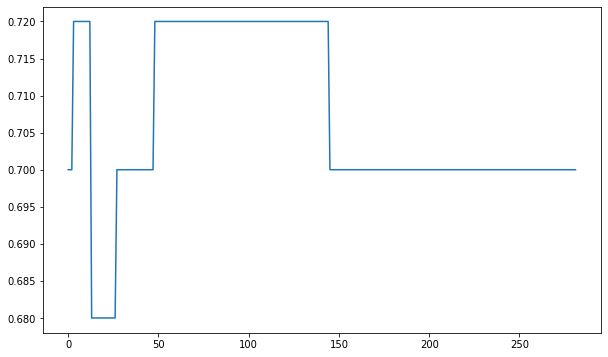

In [59]:
plt.plot(range(0,price_HOBBIES_1_015.shape[0]),price_HOBBIES_1_015)

In [60]:
p1.shape

(1913,)

In [61]:
price_HOBBIES_1_015.shape

(282,)

# RNN

Train on 1796 samples
Epoch 1/10
1796/1796 [==============================] - 2s 1ms/sample - loss: 63.8137
Epoch 2/10
1796/1796 [==============================] - 1s 790us/sample - loss: 55.8924
Epoch 3/10
1796/1796 [==============================] - 1s 824us/sample - loss: 55.6810
Epoch 4/10
1796/1796 [==============================] - 2s 875us/sample - loss: 55.5563
Epoch 5/10
1796/1796 [==============================] - 1s 800us/sample - loss: 55.2742
Epoch 6/10
1796/1796 [==============================] - 2s 1ms/sample - loss: 55.3325
Epoch 7/10
1796/1796 [==============================] - 2s 936us/sample - loss: 54.9339
Epoch 8/10
1796/1796 [==============================] - 2s 1ms/sample - loss: 54.7517
Epoch 9/10
1796/1796 [==============================] - 3s 2ms/sample - loss: 54.5566
Epoch 10/10
1796/1796 [==============================] - 2s 1ms/sample - loss: 54.4333


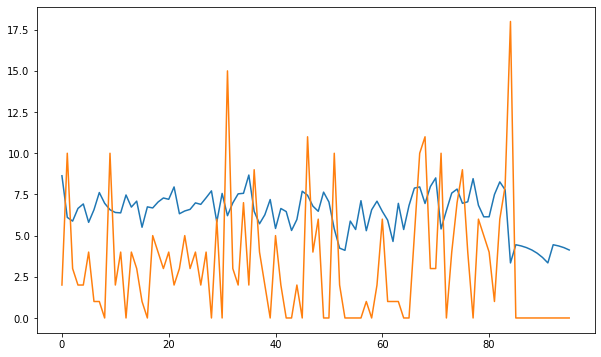

In [62]:
simple_lstm_model = keras.Sequential()
simple_lstm_model.add(keras.layers.LSTM(units=128,input_shape=shape))
simple_lstm_model.add(keras.layers.Dense(units=1))
simple_lstm_model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)
simple_lstm_model.fit(train_x,train_y,epochs=10)
pred_y = simple_lstm_model.predict(test_x)
plt.plot(range(0 ,pred_y.shape[0]),pred_y)
plt.plot(range(0 ,test_y.shape[0]),test_y)

In [ ]:
for epoch in range(epochs):
   # Split data to batches
   for idx in range(0, data.shape[0], batch_size):
        batch_data = data[idx : min(idx + batch_size, data.shape[0]),:]
        batch_labels = labels[idx : min(idx + batch_size, labels.shape[0]),:]
        feed_dict = {x: batch_data,
                         y: batch_labels}
        _, c_loss = sess.run([train_step, combined_loss], feed_dict)

In [ ]:
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [ ]:
def rnn_model():
    simple_lstm_model = keras.Sequential()
    simple_lstm_model.add(keras.layers.LSTM(
      units=128,
    input_shape=shape
    ))
    simple_lstm_model.add(keras.layers.Dense(units=1))
    
    return simple_lstm_model

In [ ]:
qs = [0.1, 0.5, 0.9]
plt.plot(range(0 ,test_y.shape[0]),test_y)
for q in qs:
    model = rnn_model()
    model.compile(loss=lambda y,f: tilted_loss(q,y,f),  optimizer=keras.optimizers.Adam(0.001))
    model.fit(train_x,train_y, epochs=25, batch_size=8, verbose=0)
    
    # Predict the quantile
    y_pred = model.predict(test_x)
    plt.plot(range(0 ,test_y.shape[0]), y_pred, label=q) # plot out this quantile

plt.legend()    
plt.savefig('quantile.png')
plt.show()

In [ ]:
train_y.mean()

In [ ]:
test_y.mean()

In [ ]:
pred_y.mean()

In [ ]:
simple_lstm_model.get_config()

# CART

In [ ]:
#clf = svm.SVR() 
clf = RandomForestClassifier(max_depth=5, random_state=0)

In [ ]:
train_x.shape

In [ ]:
train_x_svm = np.squeeze(train_x)

In [ ]:
clf.fit(train_x_svm,train_y)

In [ ]:
y_pred_svr = clf.predict(np.squeeze(test_x))

In [ ]:
test_y.mean()

In [ ]:
y_pred_svr

In [ ]:
plt.plot(range(0 ,y_pred_svr.shape[0]),y_pred_svr)
plt.plot(range(0 ,test_y.shape[0]),test_y)

In [ ]:
p1.value_counts

In [ ]:
np.unique(train_y,return_counts=True)

In [ ]:
p1.mean()

In [ ]:
p1= p1.reset_index()

In [ ]:
p1_is_event = p1.loc[calender_data[0:1913]['is_event']!=0]

In [ ]:
c = calender_data[0:1913]['is_event']!=0

In [ ]:
p1_is_event.shape

In [ ]:
p1_is_event[0].mean()

In [ ]:
p1_peak_days = calender_data[0:p1.shape[0]].loc[p1[0]>1]

In [ ]:
p1_group_week_day = p1_peak_days.groupby('weekday')

In [ ]:
p1_group_week_day.count()

In [ ]:
p1_peak_days

## Training model only for peak sales independent of previous values

In [ ]:
p1 = prediction_data.iloc[0,:]

In [ ]:
columns_for_training = ['wday', 'month','snap_CA']

In [ ]:
p1 = p1.reset_index(drop=True)

In [ ]:
train_range = range(0,1500)
test_range = range(1500,1800)

In [ ]:
p1_train = p1.iloc[train_range]
p1_test = p1.iloc[test_range]

In [ ]:
p1_peak_days_train = calender_data[columns_for_training][0:p1_train.shape[0]].loc[p1_train>=1]
p1_peak_sales_train = p1_train.loc[p1_train>=1]

In [ ]:
p1_peak_days_test = calender_data[columns_for_training][1500:1800].loc[p1_test>=1]
p1_peak_sales_test = p1_test.loc[p1_test>=1]

categorical_features = ['event_name_1']
categorical_transformer = Pipeline(steps=[
                        ("Encoding", OneHotEncoder())
                        ])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
    ])

temp = preprocessor.fit_transform(p1_peak_days)

In [ ]:
clf = RandomForestClassifier(max_depth=5, random_state=0)

In [ ]:
clf.fit(p1_peak_days_train,p1_peak_sales_train)

In [ ]:
y_pred_peak_sales = clf.predict(p1_peak_days_test)

In [ ]:
plt.plot(range(0 ,y_pred_peak_sales.shape[0]),y_pred_peak_sales)
plt.plot(range(0 ,p1_peak_sales_test.shape[0]),p1_peak_sales_test)

In [ ]:
calender_data['is_event'].iloc[p1_peak_days_test.index].value_counts()

In [ ]:
p1_peak_days_test.shape

In [ ]:
clf.feature_importances_

In [ ]:
high_sales_p1_days = calender_data[0:p1.shape[0]].loc[p1>1]

In [ ]:
high_sales_p1_days.groupby('weekday').count()

Friday and Saturday has high probability of having high sales. We can use weekday with label encoder starting from 
friday

In [ ]:
index_high_sales_p1_days =  high_sales_p1_days.index

In [ ]:
diff = [index_high_sales_p1_days[i+1] - index_high_sales_p1_days[i] for i in range(0,len(index_high_sales_p1_days)-1)]

In [ ]:
plt.plot(range(0,len(diff)),diff)
plt.plot(range(0,len(diff)),pd.Series(diff).rolling(window = 10).mean())

In [ ]:
p1.describe()